In [90]:

lr = 1e-3
wd = 5e-5
image_size=128
batch_size=2
encoder_name="resnet18"
decoder_channels=[256,128,64]
epochs=100

In [ ]:
import wandb
from datetime import datetime

wandb_entity='longyi'
model_name = "resnet-unet"
wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "encoder_name":encoder_name,
    "decoder_channels":decoder_channels,
    "image_size" : image_size,
})
wandb.run.name = f'3d_segmentation_{model_name}_' + datetime.now().strftime("%H%M%S")
wandb.run.name

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models as models

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../code/")

from sklearn.model_selection import KFold

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [21]:
DATA_DIR = "/Volumes/SSD970/"
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, "train_images_npy")
TRAIN_SEG_DIR = os.path.join(DATA_DIR, "segmentations_npy")

## Dataset

In [124]:
nii_files = glob.glob(TRAIN_SEG_DIR + "/*.npy")
UIDs = [re.findall(f'{TRAIN_SEG_DIR}/(.*).npy', s)[0] for s in nii_files]
df = pd.DataFrame(data=UIDs, columns=['UID']).reset_index(drop=True)
# df['group'] = 0
df

,UID
0,1.2.826.0.1.3680043.10921
1,1.2.826.0.1.3680043.11988
2,1.2.826.0.1.3680043.11827
3,1.2.826.0.1.3680043.12281
4,1.2.826.0.1.3680043.12292


In [125]:
kf = KFold(5)
for group, (train_indices, val_indices) in enumerate(kf.split(df)):
    df.loc[val_indices, 'group'] = group
df.tail()

,UID,group
0,1.2.826.0.1.3680043.10921,0.0
1,1.2.826.0.1.3680043.11988,1.0
2,1.2.826.0.1.3680043.11827,2.0
3,1.2.826.0.1.3680043.12281,3.0
4,1.2.826.0.1.3680043.12292,4.0


In [111]:
# img = np.load(os.path.join(TRAIN_IMAGE_DIR, f'1.2.826.0.1.3680043.10921.npy'))
# mask = np.load(os.path.join(TRAIN_SEG_DIR, f'1.2.826.0.1.3680043.10921.npy'))
# mask = np.flip(mask, axis=0)
#
# img = np.expand_dims(img, 0)
# mask = np.expand_dims(mask, 0)
# print(img.shape, mask.shape)

(1, 339, 512, 512) (1, 339, 512, 512)


In [99]:
# 여기서 128 에 맞추기 위해서 slice 들을 뽑았다.
# n_scans = 339
# image_sizes = [128, 128, 128]
# indices = np.quantile(list(range(n_scans)), np.linspace(0., 1., image_sizes[2])).round().astype(int)
# indices

array([  0,   3,   5,   8,  11,  13,  16,  19,  21,  24,  27,  29,  32,
        35,  37,  40,  43,  45,  48,  51,  53,  56,  59,  61,  64,  67,
        69,  72,  75,  77,  80,  83,  85,  88,  90,  93,  96,  98, 101,
       104, 106, 109, 112, 114, 117, 120, 122, 125, 128, 130, 133, 136,
       138, 141, 144, 146, 149, 152, 154, 157, 160, 162, 165, 168, 170,
       173, 176, 178, 181, 184, 186, 189, 192, 194, 197, 200, 202, 205,
       208, 210, 213, 216, 218, 221, 224, 226, 229, 232, 234, 237, 240,
       242, 245, 248, 250, 253, 255, 258, 261, 263, 266, 269, 271, 274,
       277, 279, 282, 285, 287, 290, 293, 295, 298, 301, 303, 306, 309,
       311, 314, 317, 319, 322, 325, 327, 330, 333, 335, 338])

In [127]:
from monai.transforms import Compose, RandFlipd, RandAffined, Spacing, SpatialPadd, RandSpatialCropd, Resized

train_tf = Compose(transforms=[
    SpatialPadd(keys=['image', 'mask'], spatial_size=512),
    RandSpatialCropd(keys=['image', 'mask'], roi_size=512, random_size=False),
    Resized(keys=['image', 'mask'], spatial_size=(image_size, image_size, image_size), mode='nearest'),
    RandFlipd(keys=['image', 'mask'], prob=0.5, spatial_axis=2),
    RandAffined(keys=['image', 'mask'], prob=0.5, rotate_range=np.pi/12, translate_range=(image_size * 0.1), scale_range=0.1, mode='nearest')
])
val_tf = Compose(transforms=[
    SpatialPadd(keys=['image', 'mask'], spatial_size=512),
    RandSpatialCropd(keys=['image', 'mask'], roi_size=512, random_size=False),
    Resized(keys=['image', 'mask'], spatial_size=(image_size, image_size, image_size), mode='nearest'),
])

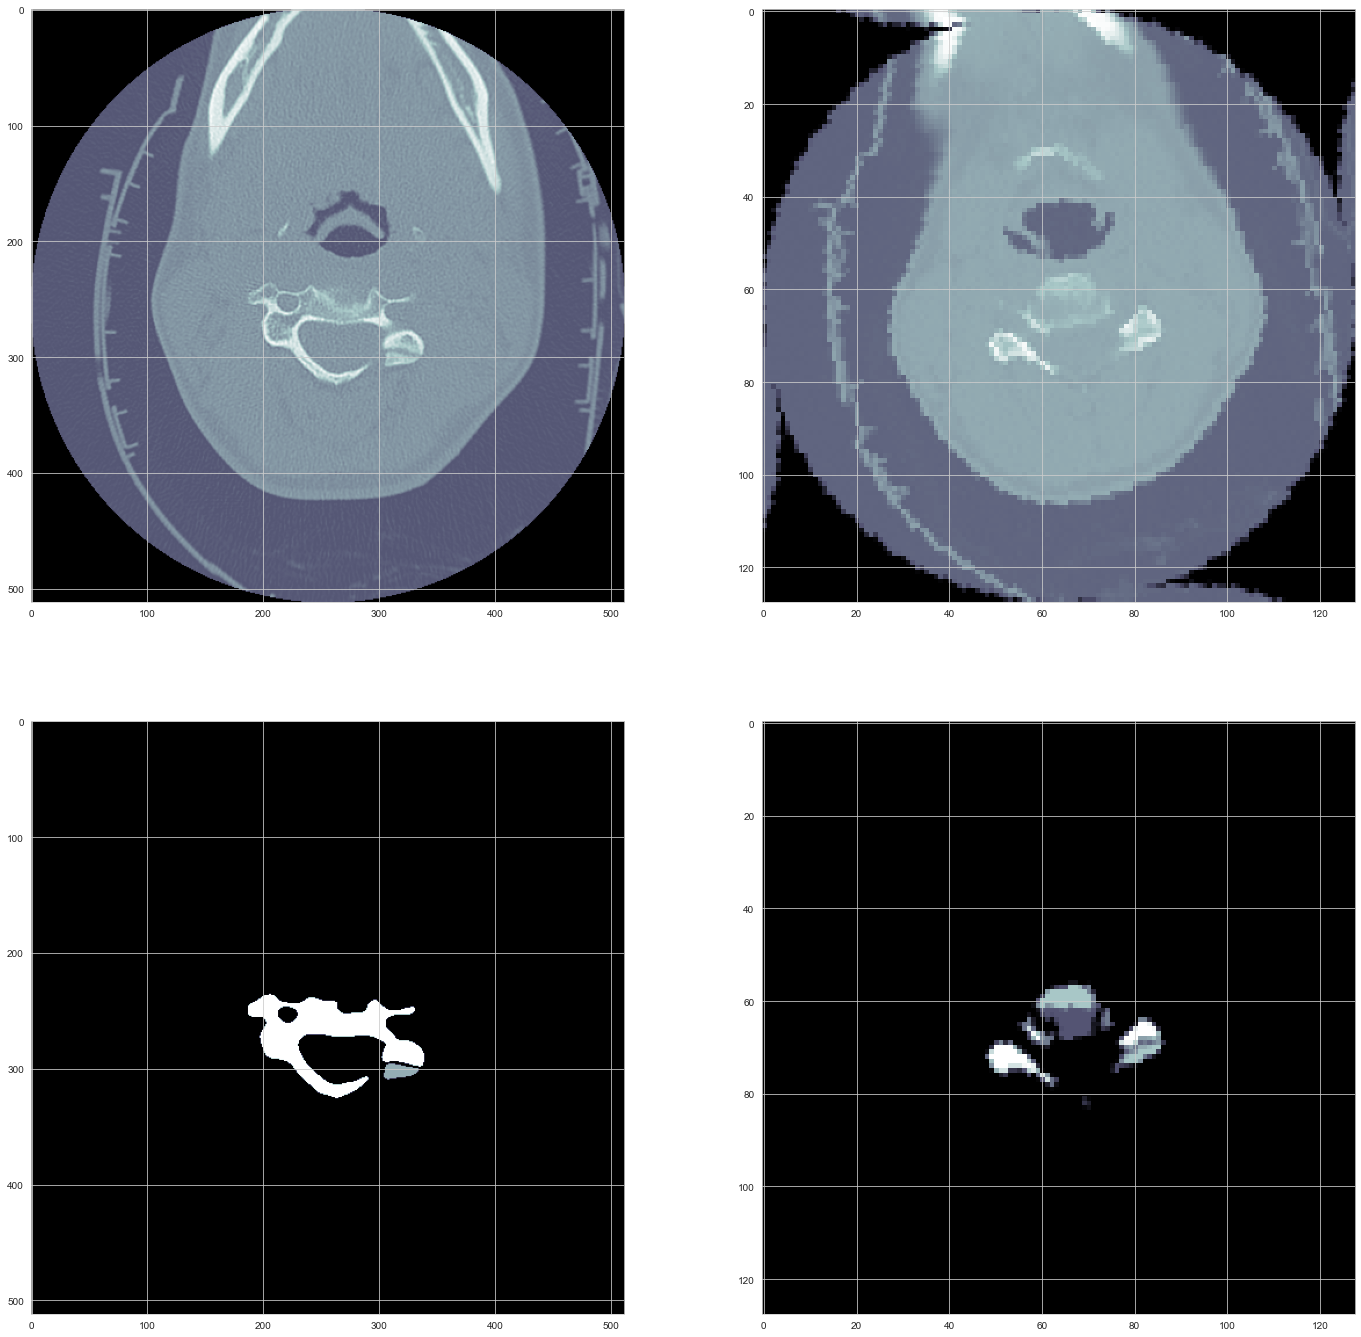

In [121]:
# out = train_tf({'image':img, 'mask':mask})
# new_img = out['image']
# new_mask = out['mask']
#
# _, axs = plt.subplots(2, 2, figsize=(24, 24))
#
# axs[0,0].imshow(img[0, 120, :, :], cmap='bone')
# axs[0,1].imshow(new_img[0, 40, :, :], cmap='bone')
#
# axs[1,0].imshow(mask[0, 120, :, :], cmap='bone')
# axs[1,1].imshow(new_mask[0, 40, :, :], cmap='bone')

In [129]:
class SegmentationDataset(Dataset):
    def __init__(self, df, image_dir, seg_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.seg_dir = seg_dir

        self.transform = transform

    def normalize_img(self, img):
        """
        normalize to -1 ~ 1
        :param img:
        :return:
        """
        min_value = img.min()
        max_value = img.max()
        img = (img - min_value) / (max_value - min_value)
        img = (img - 0.5) * 2
        return img

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        UID = self.df.iloc[idx].UID

        img = np.load(os.path.join(self.image_dir, f'{UID}.npy'))
        img = self.normalize_img(img)
        img = np.expand_dims(img, 0)

        seg = np.load(os.path.join(self.seg_dir, f'{UID}.npy'))
        seg[seg > 7.] = 0

        # TODO: 이제 몽땅 같이 flip 시키고 이걸 없애라
        seg = np.flip(seg, axis=0)

        seg = np.expand_dims(seg, 0)

        print(img.shape)
        print(seg.shape)

        if self.transform is not None:
            out = self.transform({
                            'image': img,
                            'mask' : seg
                        })
            img, seg = out['image'], out['mask']


        return img, seg


train_ds = SegmentationDataset(df[df.group == 0], TRAIN_IMAGE_DIR, TRAIN_SEG_DIR, transform=train_tf)
val_ds = SegmentationDataset(df[df.group != 0], TRAIN_IMAGE_DIR, TRAIN_SEG_DIR, transform=val_tf)
image, mask = train_ds[0]
print(image.shape)
print(mask.shape)

(1, 339, 512, 512)
(1, 339, 512, 512)
(1, 128, 128, 128)
(1, 128, 128, 128)


In [130]:
print(image.min(), image.max())
print(mask.min(), mask.max())

tensor(-1.) tensor(1.)
tensor(0.) tensor(7.)


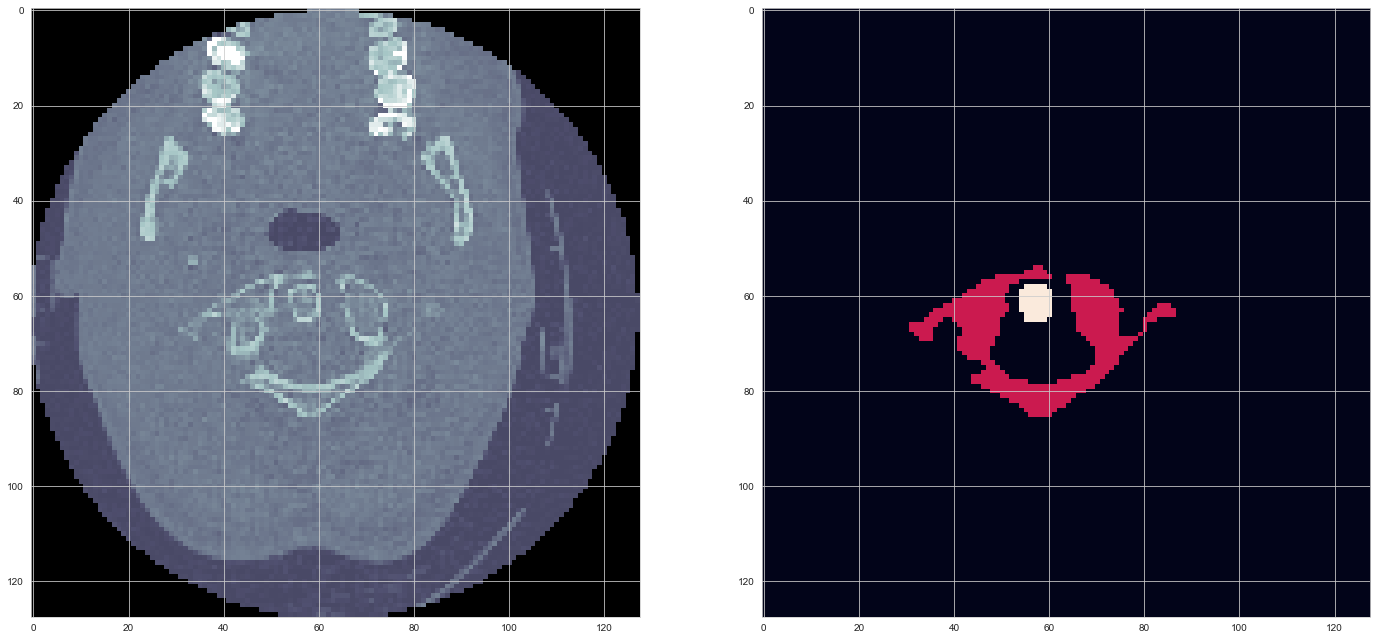

In [132]:
_, axs = plt.subplots(1, 2, figsize=(24, 12))

axs[0].imshow(image[0, 40, :, :], cmap='bone')
axs[1].imshow(mask[0, 40, :, :])

## Model

In [155]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name=encoder_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=8,                      # model output channels (number of classes in your dataset)
    encoder_depth=3, # 요게 또 묘미 였지, 이미지 사이즈를 줄이면서 이것도 함께 줄여버렷지
    decoder_channels=decoder_channels
)

In [150]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=True, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=True, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=True, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=

In [157]:
def convert_3d(module):

    new_module = module
    if isinstance(module, nn.Conv2d):
        # print(module.kernel_size)
        # print(module.bias)
        # print(torch.is_)
        new_module = nn.Conv3d(module.in_channels,
                               module.out_channels,
                               kernel_size=module.kernel_size[0],
                               stride=module.stride[0],
                               padding=module.padding[0],
                               bias=module.bias is not None)
    elif isinstance(module, nn.BatchNorm2d):
        new_module = nn.BatchNorm3d(module.num_features,
                                    module.eps,
                                    module.affine,
                                    module.track_running_stats)
    elif isinstance(module, nn.MaxPool2d):
        new_module = nn.MaxPool3d(kernel_size=module.kernel_size,
                                  stride=module.stride,
                                  padding=module.padding,
                                  dilation=module.dilation,
                                  ceil_mode=module.ceil_mode)

    for name, child_module in new_module.named_children():
        setattr(new_module, name, convert_3d(child_module))

    return new_module

model = convert_3d(model)
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=True, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=True, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=True, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def train_one_epoch(e, model, dataloader, optimizer, scaler, scheduler):

    model.train()
    train_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)

    for i, (x, y) in enumerate(train_iter):
        x = x.to(device)
        y = y.to(device)

        with torch.cuda.amp.autocast(device == 'cuda'):
            logits = model(x)
            loss = loss_fn(logits, y.squeeze(1).long())


        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()

        train_iter.set_description(f"t {e} loss {loss.item():.4f} ")

        losses.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss' : loss.item(),
                'epoch' : e,
                'train_iteration' : i + e * epoch_iteration,
                **lr_logs,
            })

    return np.mean(losses)

In [ ]:
def evaluate(e, model, dataloader):

    model.eval()
    val_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)

    for i, (x, y) in enumerate(val_iter):
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = loss_fn(logits, y.squeeze(1).long())

        val_iter.set_description(f"e {e} loss {loss.item():.4f} ")

        losses.append(loss.item())

        if wandb.run is not None:
            wandb.log({
                'val_loss' : loss.item(),
                'epoch' : e,
                'val_iteration' : i + e * epoch_iteration,
            })

    return np.mean(losses)

In [ ]:
def save_state(epoch, model, optimizer, scheduler):
    state = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "epoch": epoch,
    }
    torch.save(state, os.path.join(DATA_DIR, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth'))

In [ ]:
def run(fold):

    train_ds = SegmentationDataset(df[df.group == fold], TRAIN_IMAGE_DIR, TRAIN_SEG_DIR, transform=train_tf)
    val_ds = SegmentationDataset(df[df.group != fold], TRAIN_IMAGE_DIR, TRAIN_SEG_DIR, transform=val_tf)
    train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=min(16, batch_size))
    val_loader = DataLoader(val_ds, shuffle=False, batch_size=batch_size, num_workers=min(16, batch_size))

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=epochs)
    best_score = np.inf
    epoch = 0

    for e in range(epochs):
        train_loss = train_one_epoch(epoch, model, train_loader, optimizer, scaler, scheduler)

        scheduler.step()

        with torch.no_grad():
            val_loss = evaluate(epoch, model, val_loader)

        if val_loss < best_score:
            best_score = val_loss
            save_state(epoch, model, optimizer, scheduler)
            print('best score :', best_score)

        if wandb.run is not None:
            wandb.log({
                'train_loss': train_loss,
                'val_loss' : val_loss,
                'epoch' : epoch
            })

        epoch += 1
        if e > (epochs - 3):
            save_state(epoch, model, optimizer, scheduler)

In [ ]:
run(0)